In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def f(x, t):
    return np.cos(x) * (np.cos(t) + np.sin(t))

# Функции для начальных и краевых условий
def f_t(t):
    return np.sin(t)

def f_x(x):
    return 0

def q_l(t):
    return -np.sin(t)


# Метод прогонки для решения трехдиагональной системы
def solve_tridiagonal(a, b, c, d):
    n = len(d)
    
    c_new = np.zeros(n - 1)
    d_new = np.zeros(n)
    
    c_new[0] = c[0] / b[0]
    d_new[0] = d[0] / b[0]
    
    for i in range(1, n):
        denom = b[i] - a[i-1] * c_new[i-1]
        if i < n - 1:
            c_new[i] = c[i] / denom
        d_new[i] = (d[i] - a[i-1] * d_new[i-1]) / denom
    
    x = np.zeros(n)
    x[-1] = d_new[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = d_new[i] - c_new[i] * x[i+1]
    
    return x

def u_exact(x, t):
    return np.sin(t) * np.cos(x)

## Явная схема

Максимальная погрешность: 0.004694693025208781




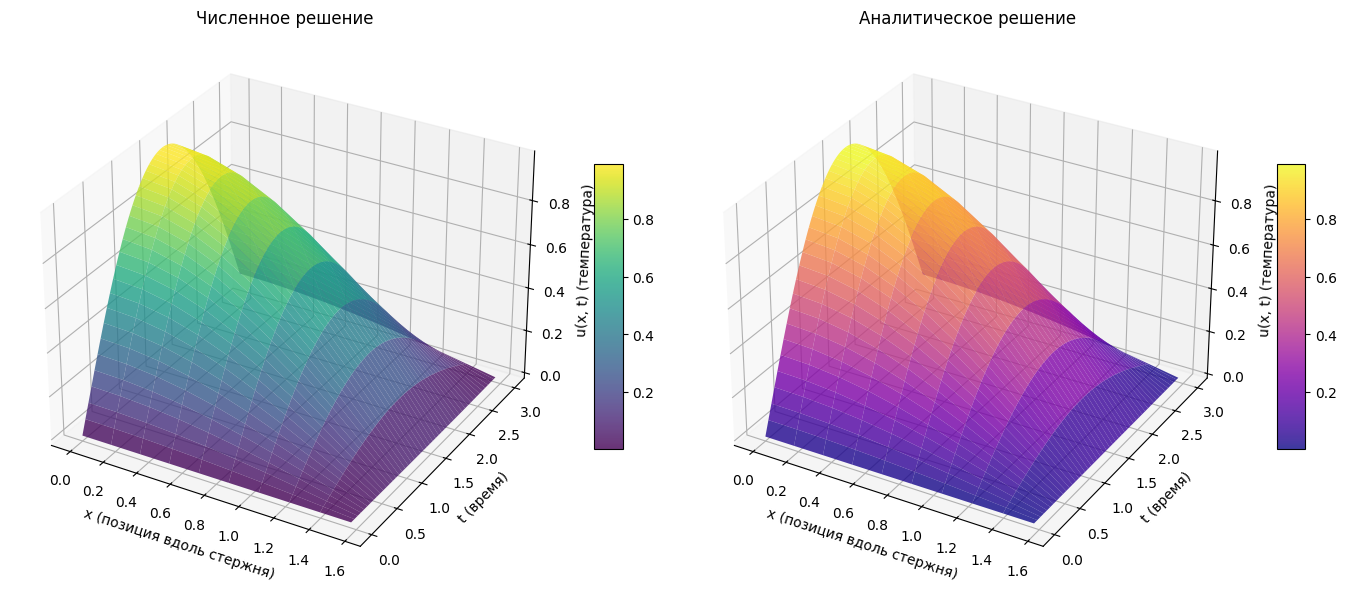

In [2]:
alpha = 1
L = np.pi / 2
T = 3.0

N = 9 
M = 1000  # Число временных слоев
h = L / N
tau = T / M

if alpha * tau / h**2 > 0.5:
    raise ValueError("Схема неустойчива: уменьшите tau или увеличьте h.")
u = np.zeros((M + 1, N + 1))

x = np.linspace(0, L, N + 1)
t = np.linspace(0, T, M + 1)
u[0, :] = f_x(x)

for n in range(M):
    # Краевое условие: u(0, t) = f(t)
    u[n + 1, 0] = f_t((n + 1) * tau)
    
    # Основное разностное уравнение
    for i in range(1, N):
        u[n + 1, i] = u[n, i] + (alpha * tau / h**2) * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1]) + tau * f(x[i], t[n])
    
    method = 1
    
    # Граничное условие для x = pi/2
    # 1. Двухточечная аппроксимация с первым порядком
    if method == 1:
        u[n + 1, -1] = u[n + 1, -2] + q_l((n + 1) * tau) * h

    # 2. Трехточечная аппроксимация со вторым порядком
    if method == 2:
        u[n + 1, -1] = (4 * u[n + 1, -2] - u[n + 1, -3] + 2 * q_l((n + 1) * tau) * h) / 3
    
    # 3. Двухточечная аппроксимация со вторым порядком
    if method == 3:
        u[n + 1, -1] = u[n + 1, -2] + h * q_l((n + 1) * tau) + (tau / 2) * (q_l((n + 1) * tau) - q_l(n * tau))

U_exact = np.array([[np.sin(ti) * np.cos(xi) for xi in x] for ti in t])

X, T = np.meshgrid(x, t)

fig = plt.figure(figsize=(14, 6))

# Левый график: Численное решение
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, T, u, cmap='viridis', alpha=0.8)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
ax1.set_title("Численное решение")
ax1.set_xlabel('x (позиция вдоль стержня)')
ax1.set_ylabel('t (время)')
ax1.set_zlabel('u(x, t) (температура)')

# Правый график: Аналитическое решение
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, T, U_exact, cmap='plasma', alpha=0.8)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_title("Аналитическое решение")
ax2.set_xlabel('x (позиция вдоль стержня)')
ax2.set_ylabel('t (время)')
ax2.set_zlabel('u(x, t) (температура)')


error = np.abs(u - U_exact)
print(f"Максимальная погрешность: {np.max(error)}\n\n")

plt.tight_layout()
plt.show()


## Неявная ##

Максимальная погрешность: 0.0626763187881481




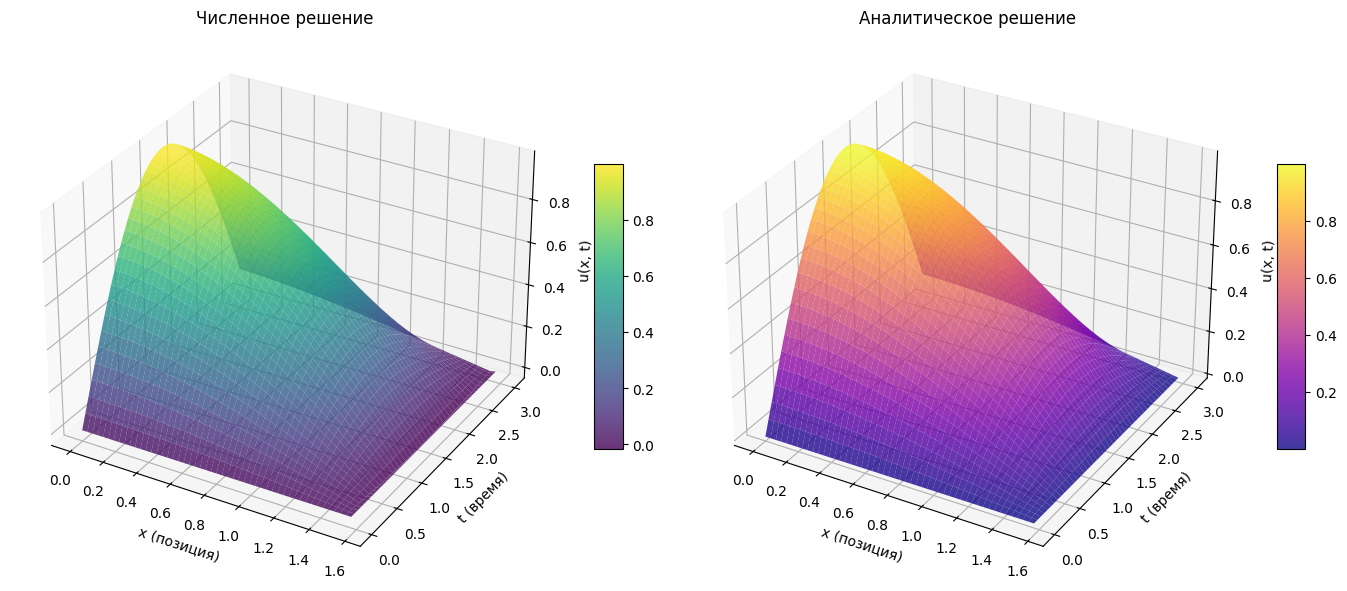

In [3]:
L = np.pi / 2
T = 3.0 
Nx = 50  # Количество узлов по x
Nt = 500  # Количество шагов по времени
dx = L / (Nx - 1)
dt = T / Nt
alpha = dt / dx**2  # Коэффициент схемы

x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt + 1)

U = np.zeros((Nt + 1, Nx))

U[0, :] = 0

# Неявная схема
for n in range(Nt):
    a = -alpha * np.ones(Nx - 2)
    b = (1 + 2 * alpha) * np.ones(Nx - 1)
    c = -alpha * np.ones(Nx - 2)
    
    d = U[n, 1:-1] + dt * f(x[1:-1], t[n+1])
    
    # Граничные условия
    d[0] += alpha * np.sin(t[n+1])
    g_t = -np.sin(t[n+1])  # Производная на правом краю
    
    method = 2
    if method == 1:  # Двухточечная аппроксимация 1-го порядка
        d[-1] -= alpha * dx * g_t
        U[n+1, -1] = U[n+1, -2] - dx * g_t
    elif method == 2:  # Трёхточечная аппроксимация 2-го порядка
        b[-1] = 1 + 2 * alpha
        d[-1] = U[n, -2] + dt * f(x[-2], t[n+1]) + 2 * dx * alpha * g_t
        U[n+1, -1] = (4 * U[n+1, -2] - U[n+1, -3]) / 3 
    elif method == 3:  # Двухточечная аппроксимация 2-го порядка
        b[-1] = 1 + 2 * alpha
        d[-1] = U[n, -2] + dt * f(x[-2], t[n+1]) + dx * alpha * g_t
        U[n+1, -1] = (3 * U[n+1, -2] - U[n+1, -3]) / 2
    
    U[n+1, 1:-1] = solve_tridiagonal(a, b, c, d)
    
    # Граничные условия
    U[n+1, 0] = np.sin(t[n+1])

U_exact = np.array([[u_exact(xi, ti) for xi in x] for ti in t])
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(14, 6))

# Левый график: Численное решение
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, T, U, cmap='viridis', alpha=0.8)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
ax1.set_title("Численное решение")
ax1.set_xlabel('x (позиция)')
ax1.set_ylabel('t (время)')
ax1.set_zlabel('u(x, t)')

# Правый график: Аналитическое решение
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, T, U_exact, cmap='plasma', alpha=0.8)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_title("Аналитическое решение")
ax2.set_xlabel('x (позиция)')
ax2.set_ylabel('t (время)')
ax2.set_zlabel('u(x, t)')


error = np.abs(U - U_exact)
print(f"Максимальная погрешность: {np.max(error)}\n\n")

plt.tight_layout()
plt.show()

## Схема Кранка-Николсона

Максимальная погрешность: 0.013351308404451747




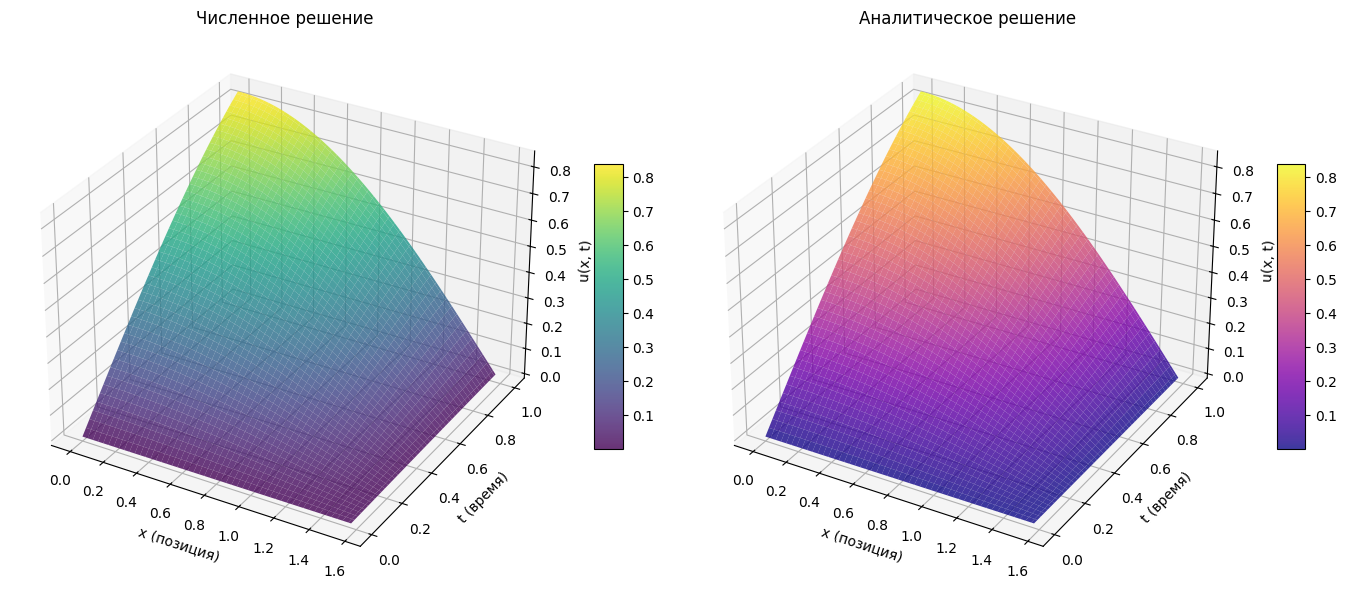

In [4]:
L = np.pi / 2
T = 1.0
Nx = 100  # Количество узлов по x
Nt = 500  # Количество шагов по времени
dx = L / (Nx - 1)
dt = T / Nt
alpha = dt / (2 * dx**2)  # Коэффициент схемы Кранка-Николсона

x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt + 1)

U = np.zeros((Nt + 1, Nx))

U[0, :] = 0

for n in range(Nt):
    a = -alpha * np.ones(Nx - 2)
    b = (1 + 2 * alpha) * np.ones(Nx - 1)
    c = -alpha * np.ones(Nx - 2)
    d = alpha * U[n, :-2] + (1 - 2 * alpha) * U[n, 1:-1] + alpha * U[n, 2:] + \
        (dt / 2) * (f(x[1:-1], t[n+1]) + f(x[1:-1], t[n]))
    
    # Граничные условия
    d[0] += alpha * np.sin(t[n+1])  # Левое граничное условие
    g_t = -np.sin(t[n+1])  # Производная на правом краю
    
    method = 1

    # Выбор метода аппроксимации
    if method == 1:  # Двухточечная аппроксимация 1-го порядка
        d[-1] -= alpha * dx * g_t
        U[n+1, -1] = U[n+1, -2] - dx * g_t
    elif method == 2:  # Трёхточечная аппроксимация 2-го порядка
        d[-1] = U[n, -2] + dt * f(x[-2], t[n+1]) + 2 * dx * alpha * g_t
        U[n+1, -1] = (4 * U[n+1, -2] - U[n+1, -3]) / 3 - (2 * dx / 3) * g_t
    elif method == 3:  # Двухточечная аппроксимация 2-го порядка
        d[-1] = U[n, -2] + dt * f(x[-2], t[n+1]) + dx * alpha * g_t
        U[n+1, -1] = (3 * U[n+1, -2] - U[n+1, -3]) / 2 - dx * g_t
    
    U[n+1, 1:-1] = solve_tridiagonal(a, b, c, d)
    
    # Граничные условия
    U[n+1, 0] = np.sin(t[n+1])

U_exact = np.array([[u_exact(xi, ti) for xi in x] for ti in t])
X, T = np.meshgrid(x, t)

fig = plt.figure(figsize=(14, 6))

# Левый график: Численное решение
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, T, U, cmap='viridis', alpha=0.8)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
ax1.set_title("Численное решение")
ax1.set_xlabel('x (позиция)')
ax1.set_ylabel('t (время)')
ax1.set_zlabel('u(x, t)')

# Правый график: Аналитическое решение
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, T, U_exact, cmap='plasma', alpha=0.8)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_title("Аналитическое решение")
ax2.set_xlabel('x (позиция)')
ax2.set_ylabel('t (время)')
ax2.set_zlabel('u(x, t)')

error = np.abs(U - U_exact)
print(f"Максимальная погрешность: {np.max(error)}\n\n")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def exponential_spline(x, y, alpha=1):
    """
    Построение экспоненциального сплайна для данных (x, y).
    Возвращает функцию-сплайн для интерполяции.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    
    n_segments = n - 1
    h = np.diff(x)
    
    # Количество переменных: 4 коэффициента на сегмент
    n_vars = 4 * n_segments
    A = np.zeros((n_vars, n_vars))
    b = np.zeros(n_vars)
    row = 0

    # Уравнения для значений в узлах
    for i in range(n_segments):
        # S_i(x_i) = y_i
        A[row, 4*i] = 1          # a_i
        A[row, 4*i+2] = 1        # c_i
        A[row, 4*i+3] = 1        # d_i
        b[row] = y[i]
        row += 1
        
        # S_i(x_{i+1}) = y_{i+1}
        A[row, 4*i] = 1                          # a_i
        A[row, 4*i+1] = h[i]                      # b_i
        A[row, 4*i+2] = np.exp(alpha * h[i])      # c_i
        A[row, 4*i+3] = np.exp(-alpha * h[i])     # d_i
        b[row] = y[i+1]
        row += 1

    # Условия непрерывности производных
    for i in range(n_segments-1):
        # Непрерывность первой производной
        A[row, 4*i+1] = 1                                    # b_i
        A[row, 4*i+2] = alpha * np.exp(alpha * h[i])         # c_i
        A[row, 4*i+3] = -alpha * np.exp(-alpha * h[i])       # d_i
        A[row, 4*(i+1)+1] = -1                               # -b_{i+1}
        A[row, 4*(i+1)+2] = -alpha                           # -c_{i+1}
        A[row, 4*(i+1)+3] = alpha                            # d_{i+1}
        row += 1
        
        # Непрерывность второй производной
        A[row, 4*i+2] = np.exp(alpha * h[i])                 # c_i
        A[row, 4*i+3] = np.exp(-alpha * h[i])                # d_i
        A[row, 4*(i+1)+2] = -1                               # -c_{i+1}
        A[row, 4*(i+1)+3] = -1                               # -d_{i+1}
        row += 1

    # Граничные условия (естественный сплайн)
    # Левая граница: c_0 + d_0 = 0
    A[row, 2] = 1
    A[row, 3] = 1
    row += 1
    
    # Правая граница: c_{n-1}*exp(alpha h) + d_{n-1}*exp(-alpha h) = 0
    i = n_segments - 1
    A[row, 4*i+2] = np.exp(alpha * h[i])
    A[row, 4*i+3] = np.exp(-alpha * h[i])
    row += 1

    # Решение системы уравнений
    coeffs = np.linalg.solve(A, b)
    
    # Создание списка коэффициентов для каждого сегмента
    spline_coeffs = []
    for i in range(n_segments):
        a = coeffs[4*i]
        b_coef = coeffs[4*i+1]
        c = coeffs[4*i+2]
        d = coeffs[4*i+3]
        spline_coeffs.append((a, b_coef, c, d, x[i], alpha))
    
    # Функция интерполяции
    def interpolate(x_query):
        x_query = np.asarray(x_query)
        result = np.zeros_like(x_query)
        for i, xi in enumerate(x_query):
            idx = np.searchsorted(x, xi) - 1
            idx = max(0, min(idx, n_segments-1))
            a, b, c, d, x0, alpha = spline_coeffs[idx]
            dx = xi - x0
            result[i] = a + b*dx + c*np.exp(alpha*dx) + d*np.exp(-alpha*dx)
        return result
    
    return interpolate

# Пример использования
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    # Тестовые данные
    x = [0, 1, 2, 3, 4]
    y = [1, 3, 2, 4, 9]
    
    # Создание сплайна
    spline = exponential_spline(x, y, alpha=1.0)
    
    # Генерация точек для визуализации
    xx = np.linspace(0, len(x) - 1, 100)
    yy = spline(xx)
    
    # Построение графика
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o', label='Исходные точки')
    plt.plot(xx, yy, label='Экспоненциальный сплайн')
    plt.title('Интерполяция экспоненциальными сплайнами')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()